In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import bayes_ame as ame
import bayes_r2 as r2

In [2]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [3]:
DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF['midpoint_farmsize']= (DF['lower_bound']+DF['upper_bound'])/2
DF.loc[DF['livestockfarm_share']== 0.0, 'livestockfarm_share']= 0.0010
DF.loc[DF['irrigated_farms']== 1.0, 'irrigated_farms']= 0.99

In [4]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

### Prepare data for Bayesian Models

In [6]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
norm_vars= ['midpoint_farmsize',
            'insured_farms','fed_income','state_income',
            'rented_land','labor_share','machinery_asset',
             'livestockfarm_share',
             'cropland_entropy','cropland_share',
              'erosion_rate', 'climate_ffp_full_year','climate_ffp_z_full_year',
              'climate_prec_growing_season','climate_prec_z_full_year']
DF1= DF[['year','Region_fips','farm_class','class','irrigated_farms','year_2017']+norm_vars]

## Standardize the complete sample except climate z values
for x in norm_vars:
    if x== 'climate_ffp_z_full_year' or x=='climate_prec_z_full_year':
        DF1[x+'_norm']= DF1[x]
    else:
        DF1[x+'_norm']= (np.log(DF1[x])- (np.log(DF1[x])).mean())/(np.log(DF1[x]).std())


# Pooled model

In [7]:
# Priors
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= 10),
    'midpoint_farmsize_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'insured_farms_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'fed_income_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'state_income_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'rented_land_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'machinery_asset_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'livestockfarm_share_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'cropland_entropy_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'cropland_share_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'erosion_rate_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_ffp_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_prec_growing_season_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_ffp_z_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'climate_prec_z_full_year_norm': bmb.Prior("Laplace", mu= 0, b= 10),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= 10)
}
## Pooled model
modelp = bmb.Model("irrigated_farms ~ 1+(midpoint_farmsize_norm)+\
                    (insured_farms_norm)+(fed_income_norm) + (state_income_norm)+\
                    (rented_land_norm)+(machinery_asset_norm)+\
                     (livestockfarm_share_norm) + \
                    (cropland_entropy_norm)+(cropland_share_norm)+\
                     (erosion_rate_norm) + (climate_ffp_full_year_norm) +\
                    (climate_prec_growing_season_norm)+(climate_ffp_z_full_year_norm)+\
                    (climate_prec_z_full_year_norm)+\
                    (year_2017)", 
                     DF1, family='beta', priors= priorsp, dropna=True)

Automatically removing 272/1146 rows from the dataset.


In [8]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [irrigated_farms_kappa, Intercept, year_2017, climate_prec_z_full_year_norm, climate_ffp_z_full_year_norm, climate_prec_growing_season_norm, climate_ffp_full_year_norm, erosion_rate_norm, cropland_share_norm, cropland_entropy_norm, livestockfarm_share_norm, machinery_asset_norm, rented_land_norm, state_income_norm, fed_income_norm, insured_farms_norm, midpoint_farmsize_norm]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.


In [9]:
az.loo(tracep)

Computed from 4000 posterior samples and 874 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   798.71    37.21
p_loo       17.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      874  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [10]:
dfp= dfsummary(tracep)
dfp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
Intercept,-0.795,0.064,-0.922,-0.679,0.001,0.001,4211.0,3076.0,1.0,Intercept,p
midpoint_farmsize_norm,-0.356,0.080,-0.507,-0.206,0.002,0.001,2729.0,2882.0,1.0,midpoint_farmsize_norm,r
insured_farms_norm,0.522,0.067,0.400,0.652,0.001,0.001,2735.0,2812.0,1.0,insured_farms_norm,r
fed_income_norm,-0.160,0.055,-0.268,-0.060,0.001,0.001,3290.0,3142.0,1.0,fed_income_norm,r
state_income_norm,-0.129,0.040,-0.204,-0.056,0.001,0.001,3253.0,2431.0,1.0,state_income_norm,r
rented_land_norm,0.047,0.068,-0.087,0.170,0.001,0.001,3330.0,2817.0,1.0,rented_land_norm,r
machinery_asset_norm,0.096,0.055,-0.006,0.205,0.001,0.001,2807.0,3091.0,1.0,machinery_asset_norm,r
livestockfarm_share_norm,-0.100,0.044,-0.181,-0.016,0.001,0.001,3543.0,2915.0,1.0,livestockfarm_share_norm,r
cropland_entropy_norm,-0.013,0.039,-0.088,0.061,0.001,0.001,3425.0,2804.0,1.0,cropland_entropy_norm,r
cropland_share_norm,-0.749,0.063,-0.867,-0.632,0.001,0.001,2354.0,2545.0,1.0,cropland_share_norm,r


In [30]:
selvars=['cons','midpoint_farmsize_norm',
         'insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm',
         'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm','climate_prec_z_full_year_norm',
         'year_2017']


varspost= ['Intercept','midpoint_farmsize_norm',
           'insured_farms_norm','fed_income_norm','state_income_norm',
           'rented_land_norm','machinery_asset_norm','livestockfarm_share_norm',
           'cropland_entropy_norm','cropland_share_norm',
            'erosion_rate_norm','climate_ffp_full_year_norm',
            'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm',
           'climate_prec_z_full_year_norm',
           'year_2017']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['irrigated_farms','midpoint_farmsize_norm','insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm','climate_ffp_z_full_year_norm',
         'climate_prec_growing_season_norm', 'year_2017'], inplace=True)


h= 0.0010 #scalar
DFamep= ame.ame_pooled(DF1_clean, tracep, selvars, varspost, h)

In [12]:
DFamep

,AME,std,CI25,CI97
cons,0.311000,5.554294e-17,0.311000,0.311000
midpoint_farmsize_norm,-0.049434,1.923611e-02,-0.088706,-0.020522
insured_farms_norm,0.072503,2.820544e-02,0.030105,0.130073
fed_income_norm,-0.022257,8.660185e-03,-0.039936,-0.009240
state_income_norm,-0.017961,6.988721e-03,-0.032228,-0.007457
rented_land_norm,0.006457,2.512309e-03,0.002681,0.011586
machinery_asset_norm,0.013325,5.184456e-03,0.005532,0.023908
livestockfarm_share_norm,-0.013932,5.420793e-03,-0.024998,-0.005784
cropland_entropy_norm,-0.001765,6.868821e-04,-0.003168,-0.000733
cropland_share_norm,-0.103985,4.046757e-02,-0.186609,-0.043165


In [31]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, tracep, 'irrigated_farms',selvars,varspost, False, x,4,1000,x)

In [32]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.7058136801381855
Lower CI: 0.686434623658033
Upper CI: 0.7226865789273801


# Hierarchical model 

In [13]:
#st_sd= bmb.Prior("HalfCauchy", beta= 1)
st_sd = 10

priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'insured_farms_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'state_income_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'livestockfarm_share_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cropland_entropy_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cropland_share_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'erosion_rate_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_ffp_full_year_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_prec_growing_season_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_ffp_z_full_year_norm|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'climate_prec_z_full_year_norm|class':bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd)
}


In [14]:
model = bmb.Model("irrigated_farms ~ 0+(1|class)+\
                    (insured_farms_norm|class)+(fed_income_norm|class) + (state_income_norm|class)+\
                    (rented_land_norm|class) + (machinery_asset_norm|class)+\
                     (livestockfarm_share_norm|class) + \
                    (cropland_entropy_norm|class)+ (cropland_share_norm|class)+\
                     (erosion_rate_norm|class) + (climate_ffp_full_year_norm|class) +\
                    (climate_prec_growing_season_norm|class)+ (climate_ffp_z_full_year_norm|class)+\
                    (climate_prec_z_full_year_norm|class)+\
                    (year_2017|class)", 
                     DF1, family='beta', priors= priorsc, dropna=True)
#
model

Formula: irrigated_farms ~ 0+(1|class)+                    (insured_farms_norm|class)+(fed_income_norm|class) + (state_income_norm|class)+                    (rented_land_norm|class) + (machinery_asset_norm|class)+                     (livestockfarm_share_norm|class) +                     (cropland_entropy_norm|class)+ (cropland_share_norm|class)+                     (erosion_rate_norm|class) + (climate_ffp_full_year_norm|class) +                    (climate_prec_growing_season_norm|class)+ (climate_ffp_z_full_year_norm|class)+                    (climate_prec_z_full_year_norm|class)+                    (year_2017|class)
Family name: Beta
Link: logit
Observations: 874
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 10)
    insured_farms_norm|class ~ Laplace(mu: 0, b: 10)
    fed_income_norm|class ~ Laplace(mu: 0, b: 10)
    state_income_norm|class ~ Laplace(mu: 0, b: 10)
    rented_land_norm|class ~ Laplace(mu: 0, b: 10)
    machinery_asset_norm|class ~ Laplace(mu: 0, 

In [15]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [irrigated_farms_kappa, year_2017|class, climate_prec_z_full_year_norm|class, climate_ffp_z_full_year_norm|class, climate_prec_growing_season_norm|class, climate_ffp_full_year_norm|class, erosion_rate_norm|class, cropland_share_norm|class, cropland_entropy_norm|class, livestockfarm_share_norm|class, machinery_asset_norm|class, rented_land_norm|class, state_income_norm|class, fed_income_norm|class, insured_farms_norm|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 104 seconds.


In [18]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[0],-0.979,0.128,-1.232,-0.747,0.002,0.002,2993.0,2432.0,1.0,1|class[0],0
insured_farms_norm|class[0],0.614,0.106,0.425,0.826,0.002,0.001,2607.0,2898.0,1.0,insured_farms_norm|class[0],0
fed_income_norm|class[0],-0.400,0.079,-0.541,-0.250,0.001,0.001,3167.0,3273.0,1.0,fed_income_norm|class[0],0
state_income_norm|class[0],0.007,0.061,-0.107,0.126,0.001,0.001,3880.0,2922.0,1.0,state_income_norm|class[0],0
rented_land_norm|class[0],-0.275,0.079,-0.427,-0.131,0.001,0.001,3728.0,3305.0,1.0,rented_land_norm|class[0],0
machinery_asset_norm|class[0],0.050,0.081,-0.099,0.197,0.001,0.001,3227.0,3267.0,1.0,machinery_asset_norm|class[0],0
livestockfarm_share_norm|class[0],0.619,0.106,0.426,0.825,0.002,0.001,3783.0,2995.0,1.0,livestockfarm_share_norm|class[0],0
cropland_entropy_norm|class[0],-0.055,0.067,-0.186,0.069,0.001,0.001,3255.0,3112.0,1.0,cropland_entropy_norm|class[0],0
cropland_share_norm|class[0],-0.774,0.098,-0.962,-0.598,0.002,0.001,2806.0,2792.0,1.0,cropland_share_norm|class[0],0
erosion_rate_norm|class[0],-0.010,0.076,-0.160,0.127,0.001,0.001,4004.0,3192.0,1.0,erosion_rate_norm|class[0],0


In [19]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[1],-1.136,0.127,-1.375,-0.902,0.002,0.002,2605.0,2724.0,1.0,1|class[1],1
insured_farms_norm|class[1],0.724,0.133,0.479,0.968,0.003,0.002,2384.0,2671.0,1.0,insured_farms_norm|class[1],1
fed_income_norm|class[1],-0.173,0.107,-0.363,0.037,0.002,0.001,2780.0,2952.0,1.0,fed_income_norm|class[1],1
state_income_norm|class[1],0.019,0.071,-0.121,0.144,0.001,0.001,3871.0,3279.0,1.0,state_income_norm|class[1],1
rented_land_norm|class[1],-0.045,0.156,-0.369,0.223,0.003,0.003,3770.0,2746.0,1.0,rented_land_norm|class[1],1
machinery_asset_norm|class[1],-0.072,0.113,-0.269,0.157,0.002,0.002,2703.0,2901.0,1.0,machinery_asset_norm|class[1],1
livestockfarm_share_norm|class[1],0.237,0.107,0.044,0.440,0.002,0.001,3218.0,3142.0,1.0,livestockfarm_share_norm|class[1],1
cropland_entropy_norm|class[1],-0.109,0.076,-0.255,0.032,0.001,0.001,3027.0,2810.0,1.0,cropland_entropy_norm|class[1],1
cropland_share_norm|class[1],-0.925,0.133,-1.188,-0.690,0.003,0.002,2343.0,2613.0,1.0,cropland_share_norm|class[1],1
erosion_rate_norm|class[1],-0.045,0.094,-0.230,0.127,0.002,0.001,3755.0,2639.0,1.0,erosion_rate_norm|class[1],1


In [20]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[2],-1.557,0.156,-1.846,-1.265,0.003,0.002,3377.0,3035.0,1.0,1|class[2],2
insured_farms_norm|class[2],0.503,0.141,0.246,0.770,0.003,0.002,3065.0,3001.0,1.0,insured_farms_norm|class[2],2
fed_income_norm|class[2],0.182,0.100,-0.012,0.370,0.002,0.001,3319.0,2868.0,1.0,fed_income_norm|class[2],2
state_income_norm|class[2],0.050,0.060,-0.060,0.163,0.001,0.001,3923.0,2887.0,1.0,state_income_norm|class[2],2
rented_land_norm|class[2],0.545,0.148,0.261,0.808,0.003,0.002,3260.0,2790.0,1.0,rented_land_norm|class[2],2
machinery_asset_norm|class[2],-0.297,0.105,-0.480,-0.089,0.002,0.001,2964.0,3203.0,1.0,machinery_asset_norm|class[2],2
livestockfarm_share_norm|class[2],-0.254,0.050,-0.345,-0.159,0.001,0.001,4391.0,3487.0,1.0,livestockfarm_share_norm|class[2],2
cropland_entropy_norm|class[2],0.008,0.058,-0.099,0.118,0.001,0.001,3372.0,3048.0,1.0,cropland_entropy_norm|class[2],2
cropland_share_norm|class[2],-0.753,0.090,-0.919,-0.574,0.002,0.001,3324.0,3001.0,1.0,cropland_share_norm|class[2],2
erosion_rate_norm|class[2],-0.179,0.074,-0.320,-0.048,0.001,0.001,4261.0,2991.0,1.0,erosion_rate_norm|class[2],2


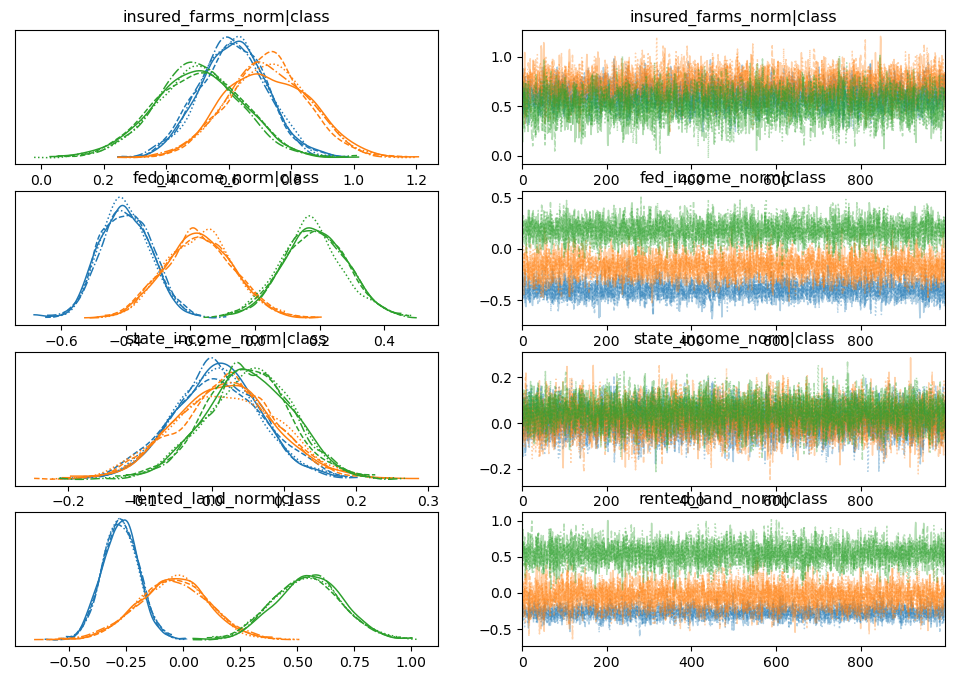

In [21]:
az.plot_trace(trace, var_names=['insured_farms_norm|class','fed_income_norm|class','state_income_norm|class','rented_land_norm|class'], compact=True);

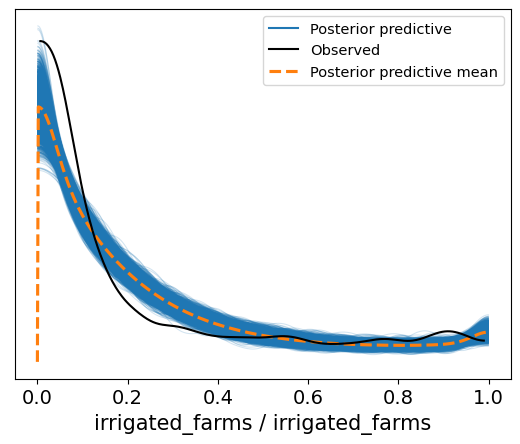

In [22]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [23]:
az.loo(trace)

Computed from 4000 posterior samples and 874 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   895.05    35.92
p_loo       46.34        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      873   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Average Marginal Effects 

In [24]:
selvars=['cons',
         'insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm','cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm',
         'climate_prec_growing_season_norm','climate_ffp_z_full_year_norm','climate_prec_z_full_year_norm',
         'year_2017']


varspost= ['1|class','insured_farms_norm|class','fed_income_norm|class','state_income_norm|class',
           'rented_land_norm|class','machinery_asset_norm|class','livestockfarm_share_norm|class',
           'cropland_entropy_norm|class','cropland_share_norm|class',
            'erosion_rate_norm|class','climate_ffp_full_year_norm|class',
            'climate_prec_growing_season_norm|class','climate_ffp_z_full_year_norm|class',
           'climate_prec_z_full_year_norm|class',
           'year_2017|class']

DF1_clean= DF1.copy()
DF1_clean.dropna(axis=0, how='any',subset=['irrigated_farms','insured_farms_norm','fed_income_norm','state_income_norm','rented_land_norm',
          'machinery_asset_norm','livestockfarm_share_norm',
         'cropland_entropy_norm', 'cropland_share_norm',
         'erosion_rate_norm','climate_ffp_full_year_norm','climate_ffp_z_full_year_norm',
         'climate_prec_growing_season_norm','climate_prec_z_full_year_norm',
                                           'year_2017'], inplace=True)


h= 0.001 #scalar
DFame= ame.ame_multilevel(DF1_clean, trace, selvars, varspost, h, 'farm_class', 3, ['Small','Medium', 'Large'])


In [25]:
DFame

,AME,std,CI25,CI97,farm_class
cons,0.273171,5.560580e-17,0.273171,0.273171,Small
insured_farms_norm,0.084289,3.717842e-02,0.023286,0.153072,Small
fed_income_norm,-0.054998,2.426519e-02,-0.099899,-0.015194,Small
state_income_norm,0.000919,4.055640e-04,0.000254,0.001670,Small
rented_land_norm,-0.037752,1.665548e-02,-0.068571,-0.010429,Small
machinery_asset_norm,0.006804,3.001374e-03,0.001880,0.012357,Small
livestockfarm_share_norm,0.085005,3.749429e-02,0.023484,0.154373,Small
cropland_entropy_norm,-0.007590,3.348603e-03,-0.013786,-0.002097,Small
cropland_share_norm,-0.106245,4.687964e-02,-0.192998,-0.029352,Small
erosion_rate_norm,-0.001351,5.961084e-04,-0.002454,-0.000373,Small


In [26]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean, trace, 'irrigated_farms',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.7058136801381855
Lower CI: 0.686434623658033
Upper CI: 0.7226865789273801


### Model comparison

In [27]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,895.054337,46.340264,0.000000,0.858332,35.923281,0.00000,False,log
pooled,1,798.708138,17.272843,96.346199,0.141668,37.212716,17.98389,False,log


In [28]:
print('Lower Bound: ', 96.346199-17.98389*2.92)
print('Upper Bound: ', 96.346199+17.98389*2.92)


Lower Bound:  43.833240200000006
Upper Bound:  148.8591578
